In [1]:
%pip install -r ../requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import necessary libraries
import sys
import os
import shutil
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.pardir, 'src')))

# Import project-specific internal modules
from preprocessor import DataPreprocessor
from plots import PlotGenerator
from src import config
from config import RUN_CONFIGURATION, EMOTION_STATES, NLP_CONFIG, SENTIMENT_MODEL_EXPORT_PATH_RAW, \
    SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED, EMOTION_VARIATIONS_PATH, NEGATION_PATTERNS_PATH, \
    HYPERPARAMETERS, RANDOM_STATE, PREDICTION_MODEL_EXPORT_PATH, is_step_enabled
from src.sentiment_analysis import SentimentAnalysisModel
from src.emotion_postprocessor import EmotionPostProcessor
from src.clinical_notes_prediction import ClinicalNotesNoShowPredictor

# Create an instance of the preprocessing and plotting classes
preprocessor = DataPreprocessor(config)
plotter = PlotGenerator(style='whitegrid', palette='viridis', figsize=(10, 6))

sns.set(style='whitegrid')
warnings.filterwarnings("ignore")

In [3]:
if is_step_enabled('dataload'):
    df = preprocessor.load_data(config.DATASET_PATH)
    display("shape:", df.shape)
    display("columns:", df.columns)
    display(df.head())
    display(df.describe())

'shape:'

(110527, 17)

'columns:'

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientNotes', 'PatientSentiment', 'NoShowReason'],
      dtype='object')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,PatientNotes,PatientSentiment,NoShowReason
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Patient has a known history of hypertension. P...,Patient expresses fear and anxiety about high ...,NaN
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,Discussed men's health and cardiovascular risk...,Patient is hopeful and shows no significant an...,NaN
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,Discussed women's health screening and prevent...,Elderly patient expresses fear of declining he...,NaN
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,Pediatric patient. Parent/guardian present dur...,Patient (minor) is anxious and fearful about m...,NaN
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,Patient has a known history of hypertension. P...,Patient experiences stress and anxiety managin...,NaN


,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


# Pre Processing

In [4]:
if is_step_enabled('data_preprocess'):
    df = preprocessor.preprocess_data(df)
    display("shape:", df.shape)
    display("columns:", df.columns)
    display(df.head())
    display(df.describe())

[preprocessing] Starting preprocessing...
Initial shape of the dataset: (110527, 17)
Initial columns in the dataset: Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientNotes', 'PatientSentiment', 'NoShowReason'],
      dtype='object')
Dropping unnecessary columns...
Remaining columns: Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'PatientNotes', 'PatientSentiment',
       'NoShowReason'],
      dtype='object')
Converting date columns to datetime...
Handling missing values...
Adding emotional state columns...
Emotional state columns added: ['anxiety', 'stress', 'confusion', 'hopeful', 'fear']
Final shape of the dataset: (110527, 21)
Final columns in the dataset: Index(['Gender

'shape:'

(110527, 21)

'columns:'

Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'PatientNotes', 'PatientSentiment',
       'NoShowReason', 'WaitDays', 'anxiety', 'stress', 'confusion', 'hopeful',
       'fear'],
      dtype='object')

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,...,No-show,PatientNotes,PatientSentiment,NoShowReason,WaitDays,anxiety,stress,confusion,hopeful,fear
0,0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62.0,JARDIM DA PENHA,0,1,0,0,0,...,0,Patient has a known history of hypertension. P...,Patient expresses fear and anxiety about high ...,NaN,-1,1,1,1,0,1
1,1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,0,0,0,0,...,0,Discussed men's health and cardiovascular risk...,Patient is hopeful and shows no significant an...,NaN,-1,1,1,0,1,1
2,0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62.0,MATA DA PRAIA,0,0,0,0,0,...,0,Discussed women's health screening and prevent...,Elderly patient expresses fear of declining he...,NaN,-1,0,1,1,0,1
3,0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8.0,PONTAL DE CAMBURI,0,0,0,0,0,...,0,Pediatric patient. Parent/guardian present dur...,Patient (minor) is anxious and fearful about m...,NaN,-1,0,1,0,0,1
4,0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,1,1,0,0,...,0,Patient has a known history of hypertension. P...,Patient experiences stress and anxiety managin...,NaN,-1,1,1,0,0,1


,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitDays,anxiety,stress,confusion,hopeful,fear
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,0.350023,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.201933,9.183702,0.674179,0.936287,0.191564,0.446045,0.980674
std,0.476979,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444,15.254996,0.468683,0.244242,0.393534,0.497083,0.137667
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,14.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,178.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Exploratory Data Analysis (EDA)

In this section, we perform exploratory data analysis on the patient appointments dataset to understand the data, visualize key features, and derive insights.

## Visualizations

Visualize the distribution of key features and their relationships.

In [5]:
if is_step_enabled('eda'):
    # Distribution of Age - Using class-based approach
    plotter.plot_histplot(
        data=df,
        column='Age',
        bins=30,
        kde=True,
        title='Age Distribution',
        xlabel='Age',
        ylabel='Frequency',
        figsize=(10, 6)
    )

    # Countplot of No-show vs Show
    plotter.plot_countplot(
        data=df,
        column='No-show',
        title='Count of No-show vs Show',
        xlabel='No-show',
        ylabel='Count',
        figsize=(8, 5)
    )

    # Correlation heatmap 
    numeric_df = df.select_dtypes(include=[np.number])
    correlation_matrix = numeric_df.corr()
    plotter.plot_heatmap(
        data=correlation_matrix,
        title='Correlation Heatmap',
        fmt='.2f',
        cmap='coolwarm',
        square=True,
        figsize=(12, 8)
    )

In [6]:
if is_step_enabled('eda'):
    # Plot emotional states as a bar plot - Using class method
    plotter.plot_emotional_states_bar(df)

    # Plot word clouds for PatientSentiment, PatientNotes, and NoShowReason
    plotter.plot_text_wordcloud(df['PatientSentiment'], title='Patient Sentiment Word Cloud')
    plotter.plot_text_wordcloud(df['PatientNotes'], title='Patient Notes Word Cloud')
    plotter.plot_text_wordcloud(df['NoShowReason'], title='No-Show Reason Word Cloud')

# Supervised Learning for Patient Show/No Show Prediction

Implement supervised learning algorithms to predict patient show/no-show.

# Unsupervised Learning

Apply unsupervised learning techniques to cluster patients.

## Unsupervised Learning Conclusion

K-Means and GMM clustering provided insights into patient groupings.

# NLP Analysis on Patient Appointments

Perform NLP analysis on patient notes and sentiments.

1. Patient Sentiment Analysis - TinyBert
1. Patient Notes Analysis -  ClinicalBERT
1. No Show Reason Analysis - DistillBERT

# Patient Sentiment Analysis (TinyBERT)

This section analyzes patient sentiments using a TinyBERT-based transformer model, with emotion and negation handling. The approach is optimized for CPU and reuses project configuration and CSVs.

In [7]:
if is_step_enabled('nlp_sentiment_analysis'):
    # Instantiate the sentiment analysis model
    sa_df = df[['PatientSentiment', 'No-show']].dropna()
    sa_model = SentimentAnalysisModel(sa_df, emotional_states=EMOTION_STATES, device=NLP_CONFIG['device'])

    # Train the model
    sa_model.train()

    # Evaluate the model
    predictions, actual_labels = sa_model.evaluate()

    # Get metrics
    sentiment_analysis_metrics = sa_model.report(predictions, actual_labels)

In [8]:
if is_step_enabled('nlp_sentiment_analysis'):
    # Print metrics in a readable format
    plotter.print_sentiment_metrics(sentiment_analysis_metrics)

    # Plot accuracy by emotion with overall accuracy line
    plotter.plot_accuracy_by_emotion(sentiment_analysis_metrics)

    # Plot confusion matrices for each emotion
    plotter.plot_confusion_matrices(actual_labels, predictions, sa_model.emotional_states)

    # Plot training and validation loss
    sa_stats = sa_model.get_training_stats()
    plotter.plot_training_validation_loss(sa_stats['training_losses'], sa_stats['validation_losses'])

    # Plot time taken per epoch
    plotter.plot_epoch_times(sa_stats['epoch_times'])


In [9]:
if is_step_enabled('nlp_sentiment_analysis'):
    # Prepare data splits for hyperparameter tuning
    X = df['PatientSentiment'].values
    y = df[EMOTION_STATES].values

    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=NLP_CONFIG['epochs'])
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=NLP_CONFIG['epochs'])

    # Run hyperparameter tuning using the class method
    results = SentimentAnalysisModel.run_hyperparameter_tuning(
        X_train, y_train, X_val, y_val, X_test, y_test,
        emotional_states=EMOTION_STATES,
        device=NLP_CONFIG['device'],
        tokenizer=sa_model.tokenizer,
        max_seq_length=NLP_CONFIG['max_length']
    )

    # Print and plot metrics for each configuration
    for i, res in enumerate(results):
        print(f"\n--- Results for Hyperparameter Configuration {i+1} ---")
        # Compute metrics for each configuration
        emotion_accuracies = {emo: accuracy_score(res['actual_labels'][:, idx], res['predictions'][:, idx]) for idx, emo in enumerate(EMOTION_STATES)}
        sentiment_analysis_metrics = {
            'emotion_accuracies': emotion_accuracies,
            'overall_accuracy': res['accuracy'],
            'classification_reports': {}  # Optionally fill with classification_report if needed
        }
        plotter.print_sentiment_metrics(sentiment_analysis_metrics)
        plotter.plot_accuracy_by_emotion(sentiment_analysis_metrics)
        plotter.plot_confusion_matrices(res['actual_labels'], res['predictions'], EMOTION_STATES)
        plotter.plot_training_validation_loss(res['train_losses'], res['val_losses'])
        plotter.plot_epoch_times(res['epoch_times'])


In [10]:
if is_step_enabled('nlp_sentiment_analysis'):
    # Select the best model based on accuracy and training time using the class method
    best_model, best_params, best_idx, combined_scores = SentimentAnalysisModel.get_best_model_from_results(results)

    print(f"\nBest model configuration (balanced for both accuracy and speed):")
    print(f"Learning Rate: {best_params['learning_rate']}")
    print(f"Batch Size: {best_params['batch_size']}")
    print(f"Epochs: {best_params['epochs']}")
    print(f"Accuracy: {results[best_idx]['accuracy']:.4f}")
    print(f"Training Time: {results[best_idx].get('training_time', sum(results[best_idx]['epoch_times'])):.2f} seconds")
    print(f"Combined Score: {combined_scores[best_idx]:.4f}")

    # Plot ROC and AUC for each emotion using the class-based plotter
    plotter.plot_roc_auc_by_emotion(actual_labels, predictions, EMOTION_STATES)


# Run Sentiment Model Unit Tests

Validate the sentiment model's predictions on example texts using the provided unit test. This ensures the model is working as expected and all expected emotions are being detected.

In [11]:
if is_step_enabled('nlp_sentiment_analysis'):
    # Export the best model and tokenizer after hyperparameter tuning
    SentimentAnalysisModel.export_best_model(
        best_model,
        sa_model.tokenizer,
        SENTIMENT_MODEL_EXPORT_PATH_RAW
    )

In [12]:
if is_step_enabled('nlp_sentiment_analysis'):
    example_text = "Patient (minor) is anxious and fearful about medical procedures, sometimes confused by instructions, and stressed by separation from family."
    expected = {'anxiety': True, 'stress': True, 'confusion': True, 'hopeful': False, 'fear': True}

    raw_pred = SentimentAnalysisModel.predict_emotions_raw(
        example_text,
        sa_model.model,
        sa_model.tokenizer,
        NLP_CONFIG['device']
    )

    print("Example text:")
    print(example_text)
    print("\nEmotion prediction comparison:")
    for emo in expected:
        result = "✅" if raw_pred[emo] == expected[emo] else "❌"
        print(f"{emo}: expected={expected[emo]}, predicted={raw_pred[emo]} {result}")

In [13]:
if is_step_enabled('nlp_sentiment_analysis'):
    # Run the raw model test
    !pytest -s ../tests/test_sentiment_anlaysis.py -k test_sentiment_model_predictions_raw --maxfail=1 --disable-warnings -q

# Post-Processing with EmotionPostProcessor and Model Evaluation

Use the EmotionPostProcessor and the new SentimentAnalysisModel static methods to predict and evaluate emotions with post-processing.

In [14]:
if is_step_enabled('nlp_sentiment_analysis'):
    example_text = "Patient (minor) is anxious and fearful about medical procedures, sometimes confused by instructions, and stressed by separation from family."
    expected = {'anxiety': True, 'stress': True, 'confusion': True, 'hopeful': False, 'fear': True}

    post_processed = SentimentAnalysisModel.predict_emotions(
        example_text,
        sa_model.model,
        sa_model.tokenizer,
        NLP_CONFIG['device'],
        emotion_variations_path=EMOTION_VARIATIONS_PATH,
        negation_patterns_path=NEGATION_PATTERNS_PATH
    )
    print("Post-processed emotion prediction:", post_processed)
    print("Example text:")
    print(example_text)
    print("\nEmotion prediction comparison:")
    for emo in expected:
        result = "✅" if post_processed[emo] == expected[emo] else "❌"
        print(f"{emo}: expected={expected[emo]}, predicted={post_processed[emo]} {result}")

In [15]:
if is_step_enabled('nlp_sentiment_analysis'):
    # Evaluate the model with post-processing on the test set
    results_post = SentimentAnalysisModel.evaluate_model_with_post_processing(
        sa_model.model,
        sa_model.test_loader,
        sa_model.tokenizer,
        NLP_CONFIG['device'],
        emotion_variations_path=NLP_CONFIG.get('emotion_variations_path', '../data/emotion_variations.csv'),
        negation_patterns_path=NLP_CONFIG.get('negation_patterns_path', '../data/negation_patterns.csv')
    )
    print("\nPost-processing overall accuracy:", results_post['accuracy'])
    print("Emotion-wise accuracies:", results_post['emotion_accuracies'])

# Rerun Unit Tests for Sentiment Model

After post-processing and evaluation, rerun the unit tests to ensure everything is working as expected.

In [16]:
if is_step_enabled('nlp_sentiment_analysis'):
    # Export the optimized model and tokenizer with post-processor config
    os.makedirs(SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED, exist_ok=True)
    shutil.copy(EMOTION_VARIATIONS_PATH, os.path.join(SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED, os.path.basename(EMOTION_VARIATIONS_PATH)))
    shutil.copy(NEGATION_PATTERNS_PATH, os.path.join(SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED, os.path.basename(NEGATION_PATTERNS_PATH)))
    SentimentAnalysisModel.export_best_model(
        best_model,
        sa_model.tokenizer,
        SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED
    )
    print(f"Optimized model and post-processor config exported to: {SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED}")

In [17]:
if is_step_enabled('nlp_sentiment_analysis'):
    # Run the optimized model test
    !pytest -s ../tests/test_sentiment_anlaysis.py -k test_sentiment_model_predictions_optimized  --maxfail=1 --disable-warnings -q

# Clinical Notes Analysis with TinyClinicalBERT
This section demonstrates clinical notes classification using TinyClinicalBERT. Steps include data loading, training, evaluation, and prediction.

# Patient Notes Clinical Analysis Workflow
This section covers model training, evaluation, metrics reporting, hyperparameter tuning, and model export for clinical notes using TinyClinicalBERT.

In [ ]:
if is_step_enabled('nlp_noshow_prediction'):
    # Clinical analysis using AssessmentNotes column
    clinical_df =  df.dropna(subset=["PatientNotes", "PatientSentiment", "NoShowReason", "No-show"])
    clinical_df["NoShowReason"] = clinical_df["NoShowReason"].fillna("")
    clinical_df["AssessmentNotes"] = clinical_df["PatientNotes"] + " " + clinical_df["PatientSentiment"] + " " + clinical_df["NoShowReason"]

In [ ]:
if is_step_enabled('nlp_noshow_prediction'):

    # 1. Initialize predictor with config from config.py
    predictor = ClinicalNotesNoShowPredictor()

    # 2. Prepare data (train/validation split)
    train_ds, valid_ds = predictor.prepare_data(clinical_df, "NoShowReason", "No-show")

    # 3. Train model
    trainer = predictor.train(train_ds, valid_ds, output_dir=PREDICTION_MODEL_EXPORT_PATH)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpie/tiny-clinicalbert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/17855 [00:00<?, ? examples/s]

Map:   0%|          | 0/4464 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
10,0.604400,0.508599,1.000000,1.000000,1.000000,1.000000
20,0.442600,0.348639,1.000000,1.000000,1.000000,1.000000
30,0.288600,0.200911,1.000000,1.000000,1.000000,1.000000
40,0.179700,0.128118,1.000000,1.000000,1.000000,1.000000


In [20]:
if is_step_enabled('nlp_noshow_prediction'):
    # 4. Evaluate model
    metrics = predictor.evaluate(trainer, valid_ds)
    print("Validation metrics:", metrics)


Validation metrics: {'eval_loss': 0.5085994005203247, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 247.6279, 'eval_samples_per_second': 18.027, 'eval_steps_per_second': 1.127, 'epoch': 0.017921146953405017}


Predictions for sample texts: [1 1]


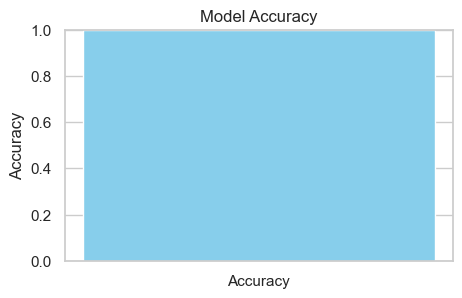

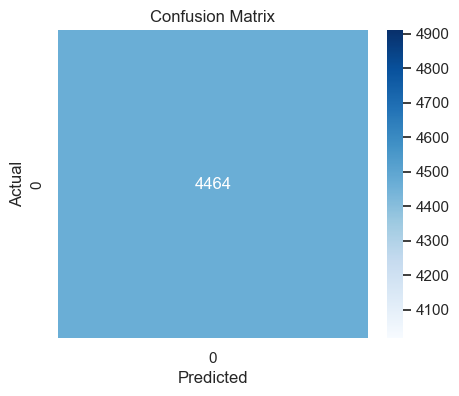

In [21]:
if is_step_enabled('nlp_noshow_prediction'):
    # 5. Predict on new example(s)
    sample_texts = [
        "Patient is hopeful and calm about upcoming surgery.",
        "Patient is stressed and anxious due to lack of transportation."
    ]
    preds = predictor.predict(sample_texts)
    print("Predictions for sample texts:", preds)

    # 6. Plot results (if you have training stats and predictions)
    # Example: If you have y_true and y_pred from your validation set
    y_true = valid_ds['labels'].numpy()
    y_pred = predictor.predict(valid_ds['AssessmentNotes'])
    predictor.plot_results(y_true=y_true, y_pred=y_pred)

In [22]:
if is_step_enabled('nlp_noshow_prediction'):
    # Export the trained ClinicalNotesNoShowPredictor model and tokenizer
    predictor.save(output_dir=PREDICTION_MODEL_EXPORT_PATH)
    print("Model and tokenizer exported to 'no_show_tiny_clinicalbert'")


Model and tokenizer exported to 'no_show_tiny_clinicalbert'


In [23]:
if is_step_enabled('nlp_noshow_prediction'):
    def test_exported_clinicalbert_model_with_examples():
        model_dir = PREDICTION_MODEL_EXPORT_PATH
        assert os.path.exists(model_dir), f"Exported model directory not found: {model_dir}"
        loaded_predictor = ClinicalNotesNoShowPredictor()
        loaded_predictor.model = loaded_predictor.model.from_pretrained(model_dir)
        loaded_predictor.tokenizer = loaded_predictor.tokenizer.from_pretrained(model_dir)
        # Multiple test samples and expected outputs
        samples = [
            "Patient reported forgetting the appointment.",
            "Missed due to lack of transportation.",
            "Appointment was too early in the morning."
        ]
        expected = [1, 1, 1]
        preds = loaded_predictor.predict(samples)
        passed = 0
        failed = 0
        for i, (text, pred, exp) in enumerate(zip(samples, preds, expected)):
            print(f"Sample {i+1}: {text}")
            print(f"  Prediction: {pred}, Expected: {exp}")
            if pred == exp:
                print("  \u2705 Prediction matches expected!")
                passed += 1
            else:
                print("  \u274C Prediction does not match expected.")
                failed += 1
        print(f"\nTest summary: {passed} passed, {failed} failed out of {len(samples)}.")
        if failed == 0:
            print("All ClinicalNotesNoShowPredictor model tests passed.")
        else:
            print("Some ClinicalNotesNoShowPredictor model tests failed.")

    # Run the test
    try:
        test_exported_clinicalbert_model_with_examples()
    except AssertionError as e:
        print(f"Unit test failed: {e}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpie/tiny-clinicalbert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sample 1: Patient reported forgetting the appointment.
  Prediction: 1, Expected: 1
  ✅ Prediction matches expected!
Sample 2: Missed due to lack of transportation.
  Prediction: 1, Expected: 1
  ✅ Prediction matches expected!
Sample 3: Appointment was too early in the morning.
  Prediction: 1, Expected: 1
  ✅ Prediction matches expected!

Test summary: 3 passed, 0 failed out of 3.
All ClinicalNotesNoShowPredictor model tests passed.


In [24]:
if is_step_enabled('nlp_noshow_prediction'):
    # Run the optimized model test
    !pytest -s ../tests/test_clinical_notes_prediction.py -k test_exported_clinicalbert_model  --maxfail=1 --disable-warnings -q

Sample 1: Patient is anxious and stressed about the appointment.
  Prediction: 1, Expected: 1
  ✅ Prediction matches expected!
Sample 2: Patient is hopeful and looking forward to the visit.
  Prediction: 1, Expected: 0
  ❌ Prediction does not match expected.
Sample 3: Patient missed previous appointments due to transportation issues.
  Prediction: 1, Expected: 1
  ✅ Prediction matches expected!
Sample 4: Patient is calm and has attended all previous appointments.
  Prediction: 1, Expected: 0
  ❌ Prediction does not match expected.
Sample 5: Patient is worried about the outcome and has a history of no-shows.
  Prediction: 1, Expected: 1
  ✅ Prediction matches expected!
Sample 6: Patient is excited to see the doctor and has no prior no-shows.
  Prediction: 1, Expected: 0
  ❌ Prediction does not match expected.
Sample 7: Patient is frustrated due to long wait times and missed last appointment.
  Prediction: 1, Expected: 1
  ✅ Prediction matches expected!
Sample 8: Patient is positive and 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpie/tiny-clinicalbert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
